In [11]:
# Import
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import requests
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import optuna
from optuna.integration import XGBoostPruningCallback
import xgboost as xgb
import torch
from scipy import stats
from sklearn.metrics import r2_score
import warnings
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")

In [2]:
def get_sp500_tickers():
    """Guncel S&P 500 Listesini cekelim."""

    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    tables = pd.read_html(response.text)
    df = tables[0]
    
    tickers = df['Symbol'].tolist()
    # Stock Price isimlendirme duzeltmesi
    tickers = [t.replace('.', '-') for t in tickers]
    return tickers

tickers = get_sp500_tickers()
print("",len(tickers), "\n",tickers[:10])

 501 
 ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [3]:
def download_data(start_date, end_date, tickers):
    """
    Belirtilen tarih araliginda Adjusted Close ve Volume verilerini indirelim.
    """
    print(f"{len(tickers)} hisse icin veri indiriliyor...")

    # yfinance ile verileri indirelim.
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

    prices = data.xs('Close', level=1, axis=1)
    volumes = data.xs('Volume', level=1, axis=1)
    return prices, volumes


# Tarih aralığı
START_DATE = "2010-01-01"
END_DATE   = "2024-12-31"

# S&P 500 güncel tickersları alalım.
tickers = get_sp500_tickers()

# Fiyat ve volume datasını çekelim.
prices_df, volumes_df = download_data(START_DATE, END_DATE, tickers)

# Eksik verisi olan stock price'ları çıkaralım. (Burada survivorship bias oluşturuyoruz ancak bunu raporumuz ekleriz.)
valid_columns = prices_df.columns[prices_df.notna().sum() > (len(prices_df) * 0.8)]
prices_df = prices_df[valid_columns]
volumes_df = volumes_df[valid_columns]

print("Veriler indirildi.")
print(f"prices_df.shape: {prices_df.shape}")
print(prices_df.head())

501 hisse icin veri indiriliyor...


[*********             19%                       ]  95 of 501 completed$Q: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[****************      34%                       ]  169 of 501 completed$SNDK: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[**********************52%                       ]  262 of 501 completed$SOLS: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[*********************100%***********************]  501 of 501 completed

5 Failed downloads:
['Q', 'SNDK', 'SOLS']: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
['ORCL', 'QCOM']: TypeErro

Veriler indirildi.
prices_df.shape: (3773, 444)
Ticker      AXON       ADSK        CAH        STE        AEE      TSCO  \
Date                                                                     
2010-01-04  4.65  25.670000  21.679621  22.825792  15.503776  2.181393   
2010-01-05  4.70  25.280001  21.486353  22.801590  15.442339  2.158490   
2010-01-06  5.84  25.340000  21.133133  22.777376  15.336229  2.153992   
2010-01-07  5.66  25.480000  21.126471  22.446575  15.191018  2.183437   
2010-01-08  5.56  26.260000  21.059830  22.333605  15.084910  2.182210   

Ticker             LH        NEM        LMT      FAST  ...       HRL  \
Date                                                   ...             
2010-01-04  62.676159  34.221478  46.781807  3.502511  ...  6.717243   
2010-01-05  61.912933  34.313316  47.268795  3.575009  ...  6.752336   
2010-01-06  60.887062  35.040810  46.574829  3.810843  ...  6.715486   
2010-01-07  60.870655  34.814796  45.296455  3.875844  ...  6.678636   
2

In [4]:
def calculate_returns(prices_df):
    """
    Log getirileri hesaplar.
    Veri kaybını önlemek için dropna() argümanını değiştiriyoruz.
    """
    returns = np.log(prices_df / prices_df.shift(1))
    
    # Sadece TÜM hisselerin boş olduğu satırları (örn: resmi tatiller) sil.
    # Tek bir hisse eksik diye günü silme.
    return returns.dropna(how='all')

# PCA kodunda PCA oncesi standardization ekledim.
def get_pca_residuals(returns_df, n_components=15, window=252):
    """
    PCA Residuals hesaplar. Veriyi standardize eder (Z-Score), 
    böylece PCA varyans yerine korelasyon yapısını yakalar.
    Makalede genellikle n_components 10-50 arası denenir (Guijarro et al. 15-50 arası kullanıyor).
    """

    residuals = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
    # Performans için numpy array'e çevirip işlem yapacağız, sonra dataframe'e basacağız
    residuals_values = np.full(returns_df.shape, np.nan)
    
    print(f"PCA Residual hesaplanıyor... (Toplam {len(returns_df) - window} gün işlenecek)")
    
    data_values = returns_df.values
    
    # PCA Modeli
    pca = PCA(n_components=n_components)

    for t in range(window, len(returns_df)):
        if t % 500 == 0: print(f"İşlenen gün: {t}")

        # 1. Eğitim Verisi (Geçmiş Window)
        # t dahil DEĞİL (t-window ... t-1) -> Look-ahead bias yok.
        train_data = data_values[t-window : t]
        
        # 2. NaN Kontrolü
        # O pencerede herhangi bir NaN'ı olan hisseyi o gün için dışarıda bırakalım
        valid_idx = ~np.isnan(train_data).any(axis=0)
        
        # O günkü getiri (Target) de NaN olmamalı
        target_valid = ~np.isnan(data_values[t])
        valid_idx = valid_idx & target_valid

        if np.sum(valid_idx) < n_components + 1:
            continue
            
        # Geçerli veriyi seç
        X_train = train_data[:, valid_idx]
        y_test = data_values[t, valid_idx].reshape(1, -1) # Bugünün getirisi
        
        # 3. Standardizasyon (ÖNEMLİ ADIM)
        # PCA'nın scale'den etkilenmemesi için.
        # Mean ve Std'yi sadece TRAIN setten öğreniyoruz.
        scaler_mean = np.mean(X_train, axis=0)
        scaler_std = np.std(X_train, axis=0) + 1e-8 # Sıfıra bölünme hatasını önle
        
        X_train_scaled = (X_train - scaler_mean) / scaler_std
        
        # PCA Fit
        pca.fit(X_train_scaled)
        
        # 4. Tahmin ve Residual
        # Bugünün verisini de AYNI mean/std ile standardize etmeliyiz
        y_test_scaled = (y_test - scaler_mean) / scaler_std
        
        # Faktörlere indirge
        factors = pca.transform(y_test_scaled)
        
        # Geri oluştur (Reconstruct)
        reconstructed_scaled = pca.inverse_transform(factors)
        
        # Scaled Residual
        res_scaled = y_test_scaled - reconstructed_scaled
        
        # Residual'ı tekrar orijinal getiri uzayına (log-return scale) döndür
        # Formül: Res_raw = Res_scaled * std 
        # (Mean eklemeye gerek yok çünkü residual farktır, mean'ler birbirini götürür)
        res_raw = res_scaled * scaler_std
        
        residuals_values[t, valid_idx] = res_raw.flatten()

    residuals_df = pd.DataFrame(residuals_values, index=returns_df.index, columns=returns_df.columns)
    return residuals_df

In [5]:
returns_df = calculate_returns(prices_df)

# Cap outliers
# returns_df = returns_df.clip(lower=returns_df.quantile(0.05), upper=returns_df.quantile(0.95), axis=1)

# Calculate residuals
residuals_df = get_pca_residuals(returns_df, n_components=5, window=252) # window size 252 - 500 denenebilir.

for col in residuals_df.columns:
    residuals_df[col] = residuals_df[col].astype(np.float64)

residuals_df = residuals_df.dropna(how='all')
print(residuals_df.tail())

PCA Residual hesaplanıyor... (Toplam 3520 gün işlenecek)
İşlenen gün: 500
İşlenen gün: 1000
İşlenen gün: 1500
İşlenen gün: 2000
İşlenen gün: 2500
İşlenen gün: 3000
İşlenen gün: 3500
Ticker          AXON      ADSK       CAH       STE       AEE      TSCO  \
Date                                                                     
2024-12-23 -0.017348 -0.002647  0.002821  0.004220  0.003481 -0.005298   
2024-12-24 -0.005998  0.000790 -0.001272 -0.003359  0.006923  0.006010   
2024-12-26 -0.009147 -0.004791  0.001639 -0.000708 -0.002195  0.016306   
2024-12-27 -0.005835  0.004091  0.003086  0.004143 -0.003293 -0.009530   
2024-12-30 -0.003118  0.016561 -0.002789 -0.000507 -0.001165 -0.025980   

Ticker            LH       NEM       LMT      FAST  ...       HRL      CTRA  \
Date                                                ...                       
2024-12-23 -0.002407 -0.007866 -0.004701 -0.004005  ... -0.003043  0.011125   
2024-12-24  0.000981 -0.001969 -0.001098 -0.002408  ...  0.000

--- Özet İstatistikler ---
Ortalama Varyans Açıklama Oranı (R^2): %48.58
(Yani hisse hareketlerinin %49'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)
Ortalama Piyasa Korelasyonu (Ham Getiri): 0.601
Ortalama Piyasa Korelasyonu (Residuals):  0.004 (Sıfıra yakın olmalı)


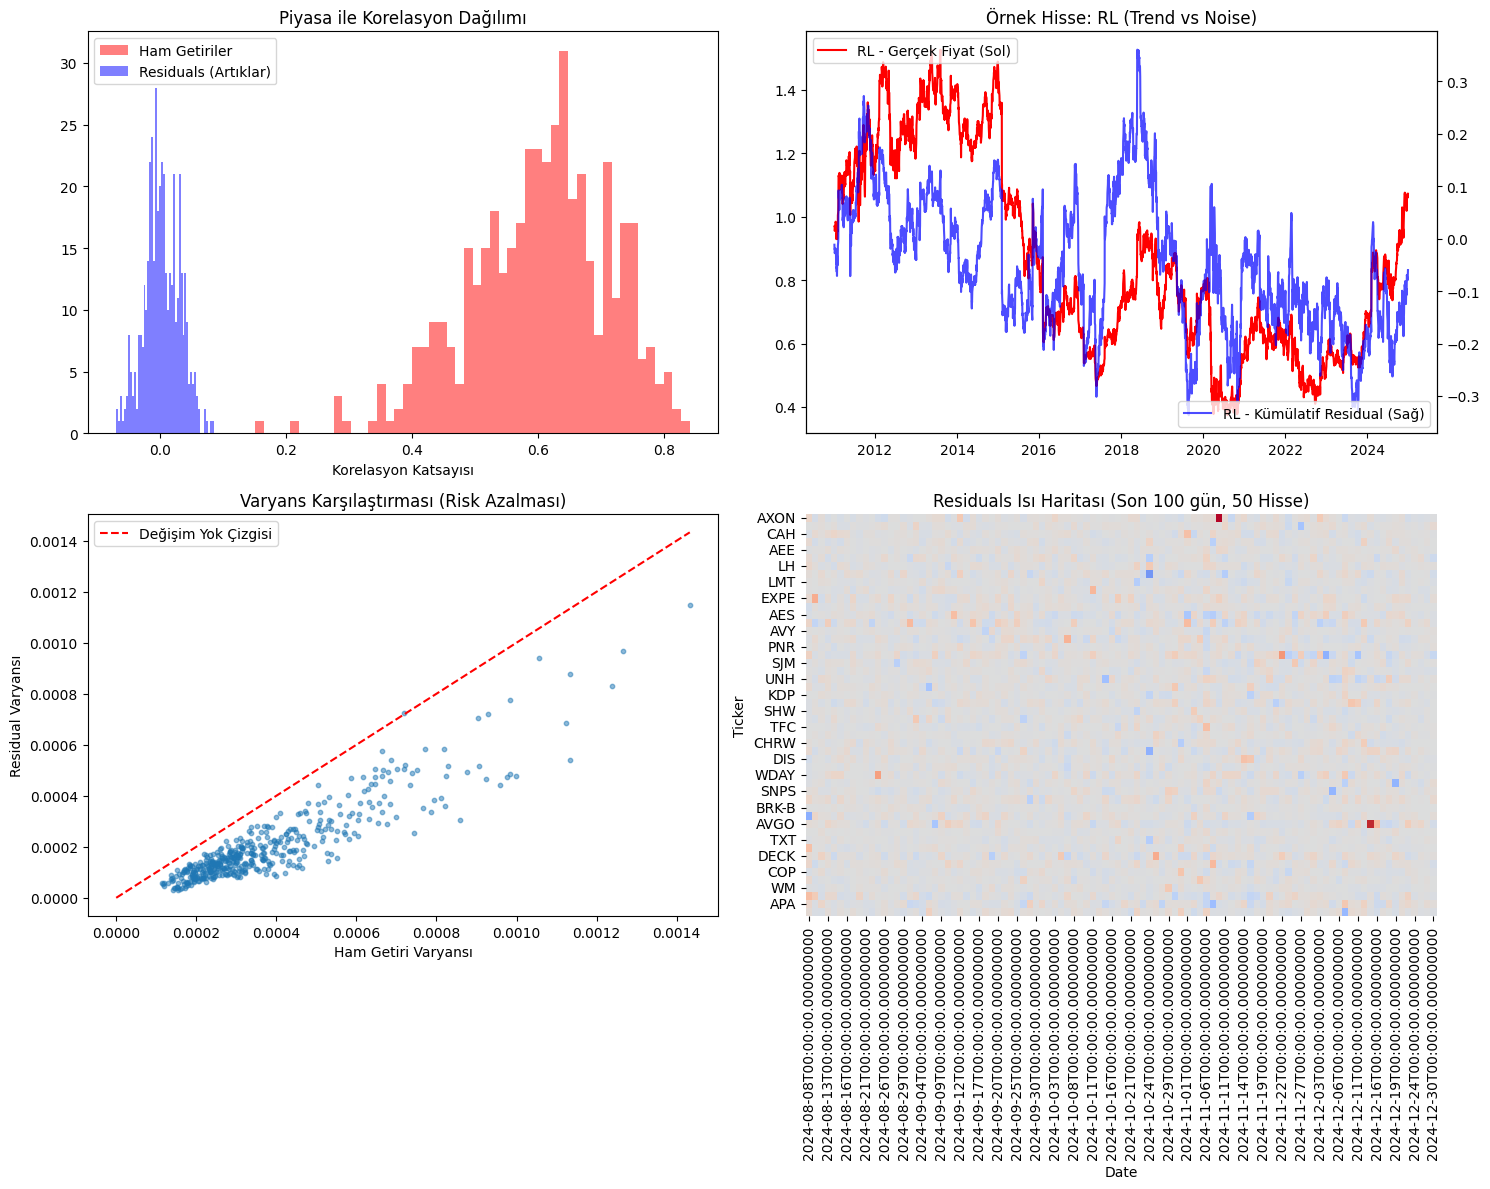

In [6]:
def analyze_residuals(returns_df, residuals_df):
    """
    Orijinal getiriler ile PCA sonrası artıkları (residuals) karşılaştırır.
    """
    
    # Ortak tarihleri hizalayalım (Residuals ilk window kadar boştur)
    valid_dates = residuals_df.dropna(how='all').index
    ret_clean = returns_df.loc[valid_dates]
    res_clean = residuals_df.loc[valid_dates]
    
    # Piyasa Proxy'si Oluşturma (Equal Weighted Index)
    # S&P 500 endeks verisi yerine, elimizdeki hisselerin ortalamasını "Piyasa" kabul edelim.
    market_return = ret_clean.mean(axis=1)
    
    # Varyans Azalması (R-Kare Benzeri Analiz)
    # Formül: 1 - (Var(Residual) / Var(Raw))
    # Bu bize "PCA faktörleri varyansın % kaçını açıkladı?" bilgisini verir.
    var_raw = ret_clean.var()
    var_res = res_clean.var()
    variance_explained = 1 - (var_res / var_raw)
    
    print(f"--- Özet İstatistikler ---")
    print(f"Ortalama Varyans Açıklama Oranı (R^2): %{variance_explained.mean()*100:.2f}")
    print(f"(Yani hisse hareketlerinin %{variance_explained.mean()*100:.0f}'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)")
    
    # Piyasa ile Korelasyon Analizi
    # Her bir hissenin piyasa ile korelasyonunu hesapla
    corr_raw = ret_clean.corrwith(market_return)
    corr_res = res_clean.corrwith(market_return)
    
    print(f"Ortalama Piyasa Korelasyonu (Ham Getiri): {corr_raw.mean():.3f}")
    print(f"Ortalama Piyasa Korelasyonu (Residuals):  {corr_res.mean():.3f} (Sıfıra yakın olmalı)")

    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Grafik A: Korelasyon Dağılımı (Histogram)
    axes[0, 0].hist(corr_raw, bins=50, alpha=0.5, label='Ham Getiriler', color='red')
    axes[0, 0].hist(corr_res, bins=50, alpha=0.5, label='Residuals (Artıklar)', color='blue')
    axes[0, 0].set_title('Piyasa ile Korelasyon Dağılımı')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Korelasyon Katsayısı')
    
    # Grafik B: Rastgele Bir Hissenin Kümülatif Getirisi vs Residual
    # Rastgele bir hisse seçelim
    sample_stock = ret_clean.columns[np.random.randint(0, len(ret_clean.columns))]
    
    cum_ret = (1 + ret_clean[sample_stock]).cumprod()
    cum_res = res_clean[sample_stock].cumsum() # Residuals log-return olduğu için toplanır (yaklaşık)
    
    ax2 = axes[0, 1]
    ax2.plot(cum_ret.index, cum_ret, label=f'{sample_stock} - Gerçek Fiyat (Sol)', color='red')
    ax2_r = ax2.twinx()
    ax2_r.plot(cum_res.index, cum_res, label=f'{sample_stock} - Kümülatif Residual (Sağ)', color='blue', alpha=0.7)
    ax2.set_title(f'Örnek Hisse: {sample_stock} (Trend vs Noise)')
    ax2.legend(loc='upper left')
    ax2_r.legend(loc='lower right')
    
    # Grafik C: Volatilite Karşılaştırması
    axes[1, 0].scatter(var_raw, var_res, alpha=0.5, s=10)
    axes[1, 0].plot([0, var_raw.max()], [0, var_raw.max()], 'r--', label='Değişim Yok Çizgisi')
    axes[1, 0].set_title('Varyans Karşılaştırması (Risk Azalması)')
    axes[1, 0].set_xlabel('Ham Getiri Varyansı')
    axes[1, 0].set_ylabel('Residual Varyansı')
    axes[1, 0].legend()
    
    # Grafik D: Residual Isı Haritası (İlk 50 hisse, son 100 gün)
    # Kümeleşme var mı diye bakıyoruz
    import seaborn as sns
    sns.heatmap(res_clean.iloc[-100:, :50].T, ax=axes[1, 1], cmap='coolwarm', center=0, cbar=False)
    axes[1, 1].set_title('Residuals Isı Haritası (Son 100 gün, 50 Hisse)')
    
    plt.tight_layout()
    plt.show()


analyze_residuals(returns_df, residuals_df)

## OU BASELINE MODEL

Derin öğrenme modelleri (CNN, Transformer), verideki desenleri (pattern) çok iyi öğrenir. Normalizasyon yaptığınızda:

- Deseni Korursunuz: "Fiyat düştü, sonra toparladı" şeklindeki hareketi (V formasyonu gibi) model hala görebilir. Bu harika.

- Genliği (Magnitude) Yok Edersiniz: Hareketin ne kadar şiddetli olduğu bilgisi (standart sapmaya bölündüğü için) kaybolur.Ancak hedef değişkeniniz ($y$) ham getiri olduğu için, genlik bilgisi hayati önem taşır.

Çözüm Nedir?

- Bilgiyi Geri Ver (Benim Önerdiğim):Modele normalize edilmiş grafiği verin (böylece şekli öğrensin), ama yanına ek bir özellik (feature) olarak "Standart Sapma" değerini de verin.
    - Girdi: [Normalize Grafik, 0.01] $\rightarrow$ Model anlar: "Şekil yukarı bakıyor ama katsayısı küçük, tahminim düşük olmalı."
    - Girdi: [Normalize Grafik, 0.10] $\rightarrow$ Model anlar: "Şekil yukarı bakıyor ve katsayısı büyük, tahminim yüksek olmalı."

- Hedefi de Normalize Et (Alternatif): Modelden ham getiriyi ($y$) değil, Sharpe Oranını ($y / \sigma$) tahmin etmesini isteyin.
    - Hisse A Hedefi: $0.005 / 0.01 = 0.5$
    - Hisse B Hedefi: $0.050 / 0.10 = 0.5$
    - Bu durumda model girdileri aynı olduğu için çıktıları da aynı (0.5) tahmin eder ve hata yapmaz. Tahmin sonrası gerçek paraya dönmek için model çıktısını tekrar o günün volatilitesi ile çarparsınız.


Sizin durumunuzda CNN+Transformer kullanacağımız ve makalede genelde Sharpe odaklı gidildiği için, Volatilite bilgisini modele ayrı bir kanal veya feature olarak vermek en sağlam yöntemdir.

In [ ]:

# Bunu silecegiz asagidaki duzgun calisirsa !
def create_ou_sequences(residuals_df, window_size=30):
    """
    Residuals DataFrame'ini OU Modeli için hazırlar.
    DEĞİŞİKLİKLER:
    1. Veri kümülatif toplama (Fiyat serisi) çevrildi.
    2. Normalizasyon KALDIRILDI (OU kendi parametrelerini tahmin etmeli).
    3. Çıktı boyutu (Samples, Window) yapıldı (3D gerekmez).
    """
    
    # 1. Adım: Residual'ları Kümülatif Fiyata Çevir (OU Seviye Bazlıdır)
    # NaN'ları 0 ile dolduruyoruz ki kümülatif toplam bozulmasın.
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    # DataFrame'i Numpy'a çevir
    data = prices_df.values
    num_days, num_stocks = data.shape
    
    X_list = []
    y_list = [] # OU için aslında 'y' (target) gerekmez ama backtest için sonraki günün getirisini tutalım.
    
    # Residuals DF orijinal halini de alalım (Target hesabı için günlük getiri lazım)
    raw_residuals = residuals_df.fillna(0.0).values
    
    print(f"OU Veri Seti oluşturuluyor... (Hisse: {num_stocks}, Gün: {num_days})")
    
    # Her hisse için döngü
    for stock_idx in tqdm(range(num_stocks)):
        stock_prices = data[:, stock_idx]
        stock_daily_ret = raw_residuals[:, stock_idx]
        
        # Kayan Pencere (Rolling Window)
        for t in range(window_size, num_days):
            
            # Girdi: t-60'dan t'ye kadar olan KÜMÜLATİF FİYAT serisi
            # OU parametreleri (kappa, sigma) bu seriden hesaplanacak.
            input_window = stock_prices[t-window_size : t]
            
            # Hedef: t anındaki (bir sonraki günün) GÜNLÜK GETİRİSİ
            # (P&L hesabı için saklıyoruz)
            target = stock_daily_ret[t]
            
            # --- NORMALİZASYON YOKTUR ---
            # OU formülü ham varyansı kullanır.
            
            X_list.append(input_window)
            y_list.append(target)

    # Listeleri Numpy Array'e çevir
    # Deep Learning olmadığı için float64 hassasiyeti OU için daha iyidir (matris tersi vb. için)
    X = np.array(X_list, dtype=np.float64)
    y = np.array(y_list, dtype=np.float64)
    
    # OU fonksiyonları genelde 1D array bekler, o yüzden 3. boyutu (channel) EKLEMİYORUZ.
    # X Shape: (Samples, 60)
    
    return X, y

def create_ou_sequences_safe(residuals_df, window_size=30):
    """
    Residuals DataFrame'ini OU Modeli için hazırlar (GÜVENLİ VERSİYON).
    Farkı: Tarihleri ve Ticker bilgilerini de saklayarak hizalama hatasını önler.
    """
    # 1. Kümülatif Fiyat Serisi Oluştur
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    data = prices_df.values
    dates = residuals_df.index      # Tarih indeksi
    tickers = residuals_df.columns  # Hisse isimleri
    
    num_days, num_stocks = data.shape
    
    # Target hesabı için günlük getiri (orijinal residual)
    raw_residuals = residuals_df.fillna(0.0).values
    
    X_list, y_list = [], []
    meta_list = [] # (Date, Ticker) bilgisini burada saklayacağız
    
    print(f"OU Veri Seti (Safe) oluşturuluyor... (Hisse: {num_stocks})")
    
    for stock_idx in tqdm(range(num_stocks)):
        stock_ticker = tickers[stock_idx]
        stock_prices = data[:, stock_idx]
        stock_daily_ret = raw_residuals[:, stock_idx]
        
        for t in range(window_size, num_days):
            # Girdi: t-window .. t-1 (Fiyat Serisi)
            input_window = stock_prices[t-window_size : t]
            
            # Hedef: t (Günlük Getiri)
            target = stock_daily_ret[t]
            target_date = dates[t]
            
            X_list.append(input_window)
            y_list.append(target)
            
            # KRİTİK EKLEME: Hangi tarih ve hangi hisse olduğunu kaydediyoruz
            meta_list.append((target_date, stock_ticker))

    X = np.array(X_list, dtype=np.float64)
    y = np.array(y_list, dtype=np.float64)
    
    return X, y, meta_list

In [ ]:
# ============================================================================
# ORNSTEIN-UHLENBECK (OU) MODEL BENCHMARK
# Makale: Section II.D.1, Avellaneda & Lee (2010), Yeo & Papanicolaou (2017)
# ============================================================================

def estimate_ou_parameters(cumulative_residuals):
    """
    Ornstein-Uhlenbeck process parametrelerini moment-based estimation ile tahmin eder.
    
    OU Process: dX_t = κ(μ - X_t)dt + σdB_t
    
    Parameters:
    -----------
    cumulative_residuals : np.array
        Cumulative residuals time series (L uzunluğunda)
    
    Returns:
    --------
    kappa : float
        Mean reversion speed
    mu : float
        Long-term mean
    sigma : float
        Volatility
    r2 : float
        Goodness of fit (R²)
    """
    x = cumulative_residuals
    L = len(x)
    
    if L < 3:
        return 0.1, np.mean(x), np.std(x), 0.0
    
    # Discrete-time OU process: X_{t+1} = X_t + κ(μ - X_t)Δt + σ√Δt * ε
    # Δt = 1 (daily)
    # Moment-based estimation (makale Appendix B.B)
    
    # First moment: E[X] = μ
    mu = np.mean(x)
    
    # Second moment: Var[X] = σ² / (2κ)
    # Autocovariance: Cov[X_t, X_{t+1}] = Var[X] * exp(-κ)
    
    # Variance
    var_x = np.var(x, ddof=1)
    
    # Autocovariance (lag 1)
    if L > 1:
        x_centered = x - mu
        autocov = np.mean(x_centered[:-1] * x_centered[1:])
    else:
        autocov = 0
    
    # Estimate κ from autocorrelation
    if var_x > 1e-10:
        rho = autocov / var_x  # Autocorrelation
        # rho = exp(-κ) => κ = -log(rho)
        kappa = max(0.01, -np.log(max(0.01, min(0.99, rho))))  # Clamp to avoid numerical issues
    else:
        kappa = 0.1
    
    # Estimate σ from variance: Var[X] = σ² / (2κ)
    if kappa > 1e-10:
        sigma = np.sqrt(2 * kappa * var_x)
    else:
        sigma = np.std(x)
    
    # R² calculation (goodness of fit)
    # Predict X_{t+1} = X_t + κ(μ - X_t)
    if L > 1:
        x_pred = x[:-1] + kappa * (mu - x[:-1])
        x_actual = x[1:]
        r2 = r2_score(x_actual, x_pred)
        r2 = max(0.0, min(1.0, r2))  # Clamp between 0 and 1
    else:
        r2 = 0.0
    
    return kappa, mu, sigma, r2

def ou_signal_extraction(cumulative_residuals):
    """
    OU model için signal extraction.
    Makale: θ^OU = [κ̂, μ̂, σ̂, X_L, R²]
    
    Parameters:
    -----------
    cumulative_residuals : np.array
        Cumulative residuals (L uzunluğunda)
    
    Returns:
    --------
    signal : np.array
        [kappa, mu, sigma, X_L, R2]
    """
    kappa, mu, sigma, r2 = estimate_ou_parameters(cumulative_residuals)
    x_L = cumulative_residuals[-1]  # Son değer
    
    return np.array([kappa, mu, sigma, x_L, r2])

def ou_allocation_function(signal, c_thresh=1.0, c_crit=0.1):
    """
    OU model için threshold-based allocation function.
    Makale: w^ε = -1 if (X_L - μ) / (σ/√(2κ)) > c_thresh and R² > c_crit
             w^ε = 1 if (X_L - μ) / (σ/√(2κ)) < -c_thresh and R² > c_crit
             w^ε = 0 otherwise
    
    Parameters:
    -----------
    signal : np.array
        [kappa, mu, sigma, X_L, R2]
    c_thresh : float
        Threshold parameter (default: 1.0)
    c_crit : float
        Critical R² value (default: 0.1)
    
    Returns:
    --------
    weight : float
        Allocation weight (-1, 0, or 1)
    """
    kappa, mu, sigma, x_L, r2 = signal
    
    # Avoid division by zero
    if kappa < 1e-10 or sigma < 1e-10:
        return 0.0
    
    # Normalized deviation
    z_score = (x_L - mu) / (sigma / np.sqrt(2 * kappa))
    
    # Threshold rule
    if r2 > c_crit:
        if z_score > c_thresh:
            return -1.0  # Sell (expect mean reversion down)
        elif z_score < -c_thresh:
            return 1.0   # Buy (expect mean reversion up)
    
    return 0.0  # No position

def ou_model_predict(X_test, y_test, c_thresh=1.0, c_crit=0.1):
    """
    OU model ile tüm test seti için tahmin yapar.
    
    Parameters:
    -----------
    X_test : torch.Tensor or np.array
        Test features (Batch, L, 1) - cumulative residuals
    y_test : torch.Tensor or np.array
        Test targets (Batch,)
    c_thresh : float
        Threshold parameter
    c_crit : float
        Critical R² value
    
    Returns:
    --------
    predictions : np.array
        Predicted weights
    actual_returns : np.array
        Actual returns
    """
    # Convert to numpy if needed
    if isinstance(X_test, torch.Tensor):
        X_test = X_test.cpu().numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().numpy()
    
    # Reshape if needed: (Batch, L, 1) -> (Batch, L)
    if X_test.ndim == 3:
        X_test = X_test.squeeze(-1)
    
    predictions = []
    actual_returns = []
    
    for i in range(len(X_test)):
        cumulative_residuals = X_test[i]
        
        # Extract signal
        signal = ou_signal_extraction(cumulative_residuals)
        
        # Get allocation
        weight = ou_allocation_function(signal, c_thresh=c_thresh, c_crit=c_crit)
        
        predictions.append(weight)
        actual_returns.append(y_test[i])
    
    return np.array(predictions), np.array(actual_returns)

=== OU BASELINE (SAFE MODE) ===
OU Veri Seti (Safe) oluşturuluyor... (Hisse: 444)


100%|██████████| 444/444 [00:00<00:00, 1736.08it/s]


OU Analizi Tamamlandı. ✅

   OU BASELINE SONUÇLAR (2024)
                      Sharpe  Total Return %     Vol %  Max DD %
Model                                                           
OU Baseline (BRÜT)  0.901668        1.602176  1.769841 -1.335352
OU Baseline (NET)  -0.465350       -0.817188  1.770311 -1.608283


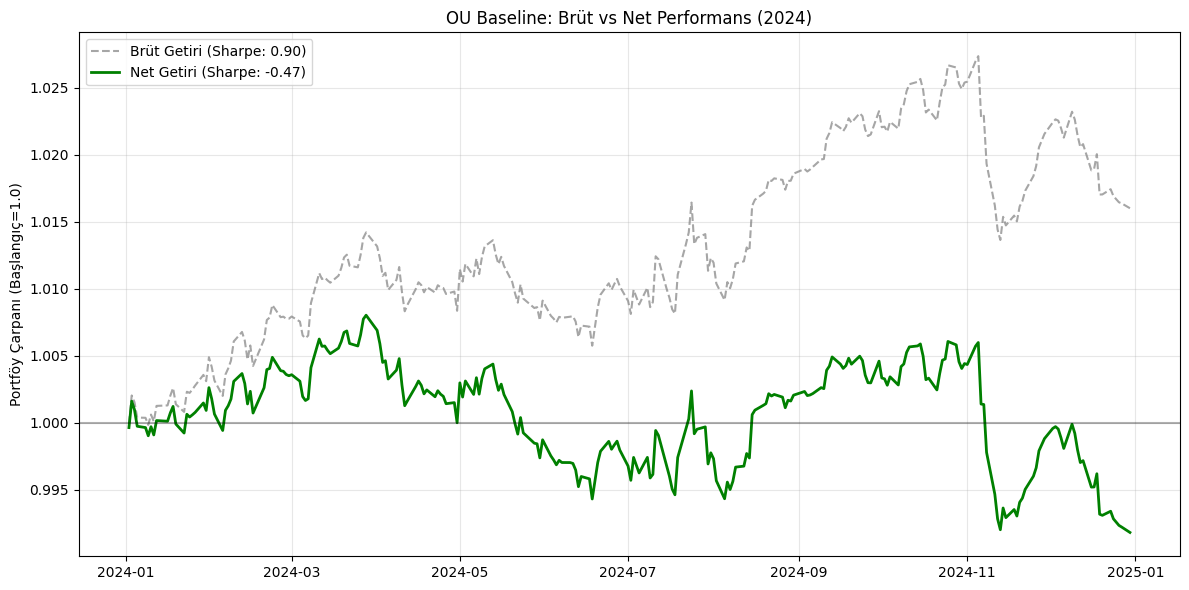

In [ ]:
# BU HÜCREYİ "TEST_YEAR = 2024" İLE BAŞLAYAN ANALİZ KISMI YERİNE YAPIŞTIR

# ==========================================================
# DÜZELTİLMİŞ OU BASELINE ANALİZİ (SAFE MODE)
# ==========================================================
TEST_YEAR = 2024
COST_BPS = 0.0005 # 5 baz puan işlem maliyeti
WINDOW_SIZE = 30  # OU pencere boyutu

print("=== OU BASELINE (SAFE MODE) ===")

# 1. Veri Hazırlığı (Buffer ekleyerek)
# Test yılından 'window_size' kadar önceye gidiyoruz ki yılın ilk günü için veri olsun.
buffer_start = pd.to_datetime(f"{TEST_YEAR}-01-01") - pd.offsets.BusinessDay(WINDOW_SIZE + 5)
df_ou_test = residuals_df.loc[buffer_start : f"{TEST_YEAR}-12-31"]

# Yeni "Safe" fonksiyonu çağırıyoruz
X_ou, y_ou, meta_ou = create_ou_sequences_safe(df_ou_test, window_size=WINDOW_SIZE)

# Modeli çalıştır (Tahmin)
# Not: ou_model_predict fonksiyonun önceki hücrelerde tanımlı olmalı
ou_preds, ou_actuals = ou_model_predict(X_ou, y_ou, c_thresh=1.0, c_crit=0.0)

# 2. DataFrame Oluşturma (Veri Kaymasını Önleyen Yöntem)
# Meta listesinden tarih ve hisse sütunlarını ayır
dates_col = [m[0] for m in meta_ou]
tickers_col = [m[1] for m in meta_ou]

df_pnl_ou = pd.DataFrame({
    'Date': dates_col,
    'Ticker': tickers_col,
    'Actual': ou_actuals,
    'Signal': ou_preds.flatten()
})

# Buffer kısmını (önceki yıldan kalan günleri) temizle, sadece 2024 kalsın
df_pnl_ou = df_pnl_ou[df_pnl_ou['Date'].dt.year == TEST_YEAR]
df_pnl_ou = df_pnl_ou.sort_values(['Ticker', 'Date']) # Sıralama önemli!

# 3. İşlem Maliyeti Hesabı (Hisse Bazında Doğru Hesap)
# Önceki günün pozisyonunu al (Ticker bazında shift ederek)
df_pnl_ou['Prev_Signal'] = df_pnl_ou.groupby('Ticker')['Signal'].shift(1).fillna(0)

# Pozisyon değişimi kadar maliyet öde (Al/Sat)
df_pnl_ou['Trade_Cost'] = np.abs(df_pnl_ou['Signal'] - df_pnl_ou['Prev_Signal']) * COST_BPS

# 4. Getiri Hesaplama
df_pnl_ou['Gross_Ret'] = df_pnl_ou['Signal'] * df_pnl_ou['Actual']
df_pnl_ou['Net_Ret'] = df_pnl_ou['Gross_Ret'] - df_pnl_ou['Trade_Cost']

# 5. Portföy Performansı (Eşit Ağırlıklı Ortalaması)
daily_metrics = df_pnl_ou.groupby('Date')[['Gross_Ret', 'Net_Ret']].mean()

daily_gross_ou = daily_metrics['Gross_Ret']
daily_net_ou = daily_metrics['Net_Ret']

print("OU Analizi Tamamlandı. ✅")

# --- RAPORLAMA ---
def calculate_metrics_final(daily_ret, name):
    ann_factor = np.sqrt(252)
    if daily_ret.std() == 0: sharpe = 0
    else: sharpe = (daily_ret.mean() / daily_ret.std()) * ann_factor
    
    total_ret_pct = (np.exp(daily_ret.sum()) - 1) * 100
    vol_pct = (daily_ret.std() * ann_factor) * 100
    
    equity = np.exp(daily_ret.cumsum())
    peak = equity.cummax()
    max_dd = ((equity - peak) / peak * 100).min()
    
    return {
        "Model": name,
        "Sharpe": sharpe,
        "Total Return %": total_ret_pct,
        "Vol %": vol_pct,
        "Max DD %": max_dd
    }

res_df = pd.DataFrame([
    calculate_metrics_final(daily_gross_ou, "OU Baseline (BRÜT)"),
    calculate_metrics_final(daily_net_ou, "OU Baseline (NET)")
])

print("\n" + "="*40)
print(f"   OU BASELINE SONUÇLAR ({TEST_YEAR})")
print("="*40)
print(res_df.set_index("Model"))

# GRAFİK
# Kümülatif Getirileri Hesapla (Log return -> Price series)
equity_gross = np.exp(daily_gross_ou.cumsum())
equity_net   = np.exp(daily_net_ou.cumsum())

plt.figure(figsize=(12, 6))

# 1. Brüt Getiri (Gri, Kesikli Çizgi - Referans)
plt.plot(equity_gross.index, equity_gross.values, 
         label=f"Brüt Getiri (Sharpe: {res_df.iloc[0]['Sharpe']:.2f})", 
         color="gray", linestyle="--", alpha=0.7)

# 2. Net Getiri (Yeşil, Kalın Çizgi - Asıl Sonuç)
plt.plot(equity_net.index, equity_net.values, 
         label=f"Net Getiri (Sharpe: {res_df.iloc[1]['Sharpe']:.2f})", 
         color="green", linewidth=2)

plt.axhline(1.0, color="black", linestyle="-", alpha=0.3)
plt.title(f"OU Baseline: Brüt vs Net Performans ({TEST_YEAR})", fontsize=12)
plt.ylabel("Portföy Çarpanı (Başlangıç=1.0)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

## XGBOOST

In [10]:
# DATASET FOR ADVANCED XGBOOST FEATURES

def calculate_rsi_numpy(series, period=14):
    """ Mevcut RSI Fonksiyonunuz """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-8)
    return 100 - (100 / (1 + rs))

def prepare_advanced_xgboost_features(residuals_df):
    """
    GELİŞTİRİLMİŞ FEATURE SETİ:
    - Skewness & Kurtosis (Dağılım bozulmalarını yakalar)
    - Volatility Ratios (Rejim değişikliklerini yakalar)
    - Bollinger Band Width (Sıkışmaları yakalar)
    """
    print("Gelişmiş XGBoost Feature Engineering yapılıyor...")
    
    # Kümülatif Fiyatlar
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    features_list = []
    
    # Pencereler
    windows = [10, 30, 60]
    lags = [1, 2, 3, 5, 10, 20, 30]
    
    for ticker in tqdm(residuals_df.columns):
        
        res_ret = residuals_df[ticker]
        res_price = prices_df[ticker]
        
        df = pd.DataFrame(index=residuals_df.index)
        
        # --- MEVCUT FEATURES (Temel) ---
        for lag in lags:
            df[f'lag_{lag}'] = res_ret.shift(lag)
            
        df['rsi_14'] = calculate_rsi_numpy(res_price, period=14)
        
        # --- YENİ & GELİŞMİŞ FEATURES ---
        for w in windows:
            roll_mean = res_price.rolling(window=w).mean()
            roll_std  = res_price.rolling(window=w).std()
            
            # 1. Z-Score (Klasik)
            df[f'zscore_{w}'] = (res_price - roll_mean) / (roll_std + 1e-8)
            
            # 2. Volatilite (Klasik)
            df[f'vol_{w}'] = roll_std
            
            # 3. YENİ: Skewness (Çarpıklık)
            # Modelin "Bu hareket normal mi yoksa bir haber mi geldi?" ayrımı yapmasını sağlar.
            # En az 20 gün veri gerekir, o yüzden w < 20 ise atlayabiliriz veya 20 yaparız.
            if w >= 30: 
                df[f'skew_{w}'] = res_price.rolling(window=w).skew()
                df[f'kurt_{w}'] = res_price.rolling(window=w).kurt()
            
            # 4. YENİ: Bollinger Band Width (BBW)
            # Bantlar ne kadar geniş? Geniş bant = Yüksek Risk/Fırsat
            upper = roll_mean + (2 * roll_std)
            lower = roll_mean - (2 * roll_std)
            df[f'bb_width_{w}'] = (upper - lower) / (roll_mean + 1e-8)
            
            # 5. YENİ: Distance to Max/Min (Son w gündeki zirveye/dibe uzaklık)
            # Mean Reversion için kritik: "Dibe ne kadar yakınız?"
            roll_max = res_price.rolling(window=w).max()
            roll_min = res_price.rolling(window=w).min()
            
            # (Fiyat - Min) / (Max - Min) -> Stokastik Osilatör Mantığı
            df[f'stoch_{w}'] = (res_price - roll_min) / (roll_max - roll_min + 1e-8)

        # 6. YENİ: Volatility Ratio (Kısa Vade / Uzun Vade)
        # Volatilite artıyor mu azalıyor mu?
        # 10 günlük vol / 60 günlük vol
        vol_10 = res_price.rolling(window=10).std()
        vol_60 = res_price.rolling(window=60).std()
        df['vol_ratio'] = vol_10 / (vol_60 + 1e-8)
        
        # 7. YENİ: Time Features (Zamanlama)
        # One-Hot Encoding yerine Tree modelleri için Ordinal (0-4) yeterlidir.
        #df['day_of_week'] = df.index.dayofweek # 0=Pzt, 4=Cuma
        #df['month_of_year'] = df.index.month
        
        # --- TARGET ---
        df['target_return'] = res_ret.shift(-1)
        
        df = df.dropna()
        features_list.append(df)
    
    full_dataset = pd.concat(features_list)
    full_dataset = full_dataset.astype(np.float32)
    
    return full_dataset

# Kodu Çalıştır
xgb_dataset = prepare_advanced_xgboost_features(residuals_df)

# Feature ve Target sütunlarını belirle
feature_cols = [c for c in xgb_dataset.columns if c != 'target_return']
target_col   = 'target_return'

print("\nGelişmiş Veri Seti Hazır!")
print(f"Yeni Boyutlar: {xgb_dataset.shape}")
print("Örnek Feature İsimleri:", xgb_dataset.columns[:10].tolist())

Gelişmiş XGBoost Feature Engineering yapılıyor...


100%|██████████| 444/444 [00:02<00:00, 215.50it/s]



Gelişmiş Veri Seti Hazır!
Yeni Boyutlar: (1527431, 26)
Örnek Feature İsimleri: ['lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'lag_20', 'lag_30', 'rsi_14', 'zscore_10', 'vol_10']


In [12]:
# ==========================================================
# 1. VERİ HAZIRLIĞI (2011 - 2023)
# ==========================================================
OPT_START_YEAR = 2011
OPT_END_YEAR   = 2023

print(f"Optimizasyon Havuzu: {OPT_START_YEAR} - {OPT_END_YEAR} (2024 Hariç)")

mask_opt = (xgb_dataset.index.year >= OPT_START_YEAR) & (xgb_dataset.index.year <= OPT_END_YEAR)
X_opt = xgb_dataset.loc[mask_opt, feature_cols]
y_opt = xgb_dataset.loc[mask_opt, 'target_return']

# ==========================================================
# 2. CUSTOM TIME SERIES SPLITTER
# ==========================================================
def get_expanding_window_splits(df_index, n_folds=5):
    years = sorted(df_index.year.unique())
    val_years = years[-n_folds:]
    
    splits = []
    for v_year in val_years:
        val_mask = (df_index.year == v_year)
        train_mask = (df_index.year < v_year) & (df_index.year >= years[0])
        
        train_idx = np.where(train_mask)[0]
        val_idx   = np.where(val_mask)[0]
        
        splits.append((train_idx, val_idx, v_year))
        
    return splits

splits = get_expanding_window_splits(X_opt.index, n_folds=5)

# ==========================================================
# 3. OPTUNA OBJECTIVE FUNCTION (DÜZELTİLDİ)
# ==========================================================
def objective(trial):
    # Hiperparametre Uzayı
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 250, step=5),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 10), 
        'min_child_weight': trial.suggest_int('min_child_weight', 30, 70),
        'gamma': trial.suggest_float('gamma', 0.0001, 0.005, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.55, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 6.0, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 6.0, log=True),
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42
    }
    
    threshold = trial.suggest_float('threshold', 0.00005, 0.002, log=True)
    fold_scores = []
    
    # Pruning Callback
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    
    for train_idx, val_idx, v_year in splits:
        X_train_fold, X_val_fold = X_opt.iloc[train_idx], X_opt.iloc[val_idx]
        y_train_fold, y_val_fold = y_opt.iloc[train_idx], y_opt.iloc[val_idx]
        
        # --- DÜZELTME BURADA YAPILDI ---
        # callbacks parametresi .fit() içinden alınıp buraya taşındı:
        model = xgb.XGBRegressor(**params, callbacks=[pruning_callback])
        
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        preds = model.predict(X_val_fold)
        
        signals = np.zeros_like(preds)
        signals[preds > threshold] = 1
        signals[preds < -threshold] = -1
        
        rets = signals * y_val_fold.values
        std_ret = np.std(rets)
        
        if std_ret < 1e-9:
            sharpe = 0.0
        else:
            sharpe = np.mean(rets) / std_ret * np.sqrt(252)
        
        n_trades = np.sum(signals != 0)
        if n_trades < 50: 
            sharpe = sharpe * (n_trades / 50.0)
            
        fold_scores.append(sharpe)
    
    return np.mean(fold_scores)

# ==========================================================
# 4. OPTİMİZASYONU BAŞLAT
# ==========================================================
print("\nOptuna Optimizasyonu Başlatılıyor... (Pruning Aktif - Düzeltildi)")

study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.HyperbandPruner(min_resource=50) 
)

# Deneme sayısını 150 yaptım, pruning olduğu için hızlı bitecektir.
study.optimize(objective, n_trials=150) 

print("\n=== EN İYİ SONUÇLAR ===")
print(f"Best Mean Sharpe (CV): {study.best_value:.4f}")
print("Best Params:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_params = study.best_params
BEST_THRESHOLD = best_params.pop('threshold')

print(f"\nFinal Threshold: {BEST_THRESHOLD}")
print(f"Final XGBoost Params: {best_params}")

Optimizasyon Havuzu: 2011 - 2023 (2024 Hariç)


[I 2025-12-30 16:22:10,841] A new study created in memory with name: no-name-1d2cecb2-7d09-48a7-8c7b-dadee3e826fb



Optuna Optimizasyonu Başlatılıyor... (Pruning Aktif - Düzeltildi)


[I 2025-12-30 16:22:25,799] Trial 0 finished with value: 0.1823783767265645 and parameters: {'n_estimators': 170, 'learning_rate': 0.09484448908397926, 'max_depth': 6, 'min_child_weight': 66, 'gamma': 0.0001100034700120292, 'subsample': 0.7798589995622472, 'colsample_bytree': 0.5778686384572562, 'reg_alpha': 3.6358050386959624, 'reg_lambda': 0.043181053027170214, 'threshold': 9.394307767027956e-05}. Best is trial 0 with value: 0.1823783767265645.
[I 2025-12-30 16:22:38,826] Trial 1 finished with value: 0.15343227042468927 and parameters: {'n_estimators': 225, 'learning_rate': 0.012947019029807025, 'max_depth': 10, 'min_child_weight': 31, 'gamma': 0.004905406848454134, 'subsample': 0.8840107757195084, 'colsample_bytree': 0.7982709758698314, 'reg_alpha': 0.02891738878214342, 'reg_lambda': 0.030038379204055495, 'threshold': 0.00019567448167629836}. Best is trial 0 with value: 0.1823783767265645.
[I 2025-12-30 16:22:53,421] Trial 2 finished with value: 0.18617463285684882 and parameters: {


=== EN İYİ SONUÇLAR ===
Best Mean Sharpe (CV): 0.2014
Best Params:
  n_estimators: 115
  learning_rate: 0.006187043793181182
  max_depth: 8
  min_child_weight: 59
  gamma: 0.0003472047368403349
  subsample: 0.8820711574534718
  colsample_bytree: 0.6968501492817246
  reg_alpha: 1.3068960400606218
  reg_lambda: 0.13764308218497623
  threshold: 9.476419465910512e-05

Final Threshold: 9.476419465910512e-05
Final XGBoost Params: {'n_estimators': 115, 'learning_rate': 0.006187043793181182, 'max_depth': 8, 'min_child_weight': 59, 'gamma': 0.0003472047368403349, 'subsample': 0.8820711574534718, 'colsample_bytree': 0.6968501492817246, 'reg_alpha': 1.3068960400606218, 'reg_lambda': 0.13764308218497623}


In [13]:
best_params

{'n_estimators': 115,
 'learning_rate': 0.006187043793181182,
 'max_depth': 8,
 'min_child_weight': 59,
 'gamma': 0.0003472047368403349,
 'subsample': 0.8820711574534718,
 'colsample_bytree': 0.6968501492817246,
 'reg_alpha': 1.3068960400606218,
 'reg_lambda': 0.13764308218497623}

In [14]:
BEST_THRESHOLD

9.476419465910512e-05

=== FINAL TEST (2024) ===
Model Konfigürasyonu: {'n_estimators': 115, 'learning_rate': 0.006187043793181182, 'max_depth': 8, 'min_child_weight': 59, 'gamma': 0.0003472047368403349, 'subsample': 0.8820711574534718, 'colsample_bytree': 0.6968501492817246, 'reg_alpha': 1.3068960400606218, 'reg_lambda': 0.13764308218497623, 'objective': 'reg:squarederror', 'n_jobs': -1, 'random_state': 42}
İşlem Eşiği: 0.00009476

Genişletilmiş Eğitim Seti (2011-2023): (1416431, 25)
Test Seti (2024)                     : (111000, 25)

Model Eğitiliyor... (Hedef: 115 Ağaç)
Eğitim Tamamlandı.

2024 Tahminleri Yapılıyor...

   XGBOOST FINAL RAPORU (2024)
Toplam Sinyal Sayısı : 25413
Win Rate (İşlem Baş.) : %50.76
----------------------------------------
Model           Sharpe     Return %     Max DD %  
----------------------------------------
XGBoost (Brüt)  2.2380     3.26         -0.74
XGBoost (NET)   0.1834     0.26         -1.33


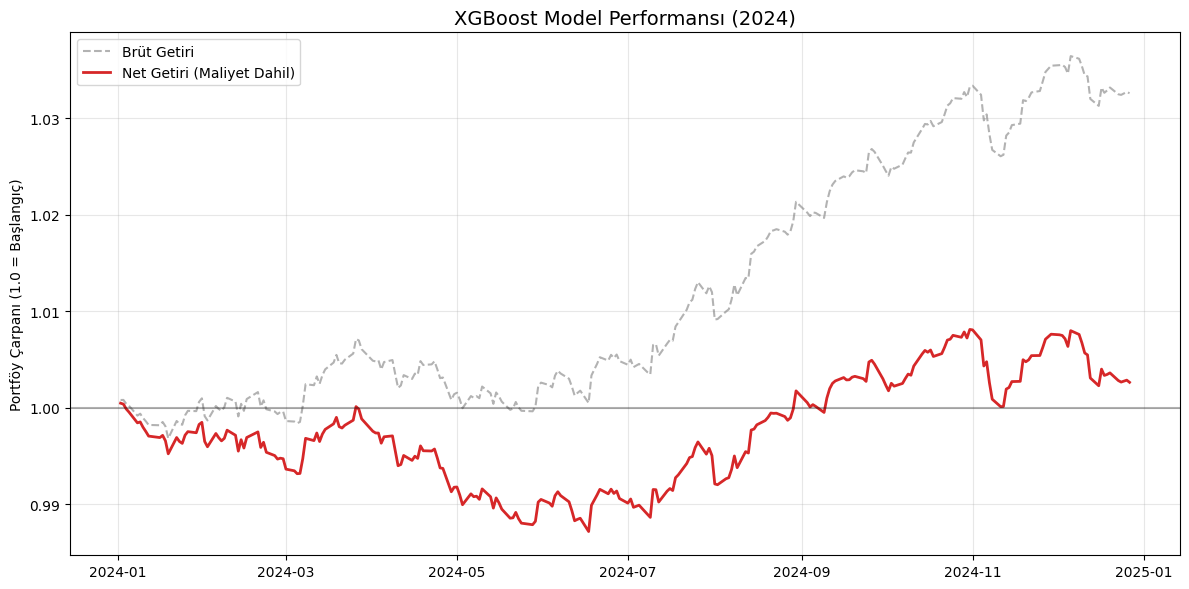

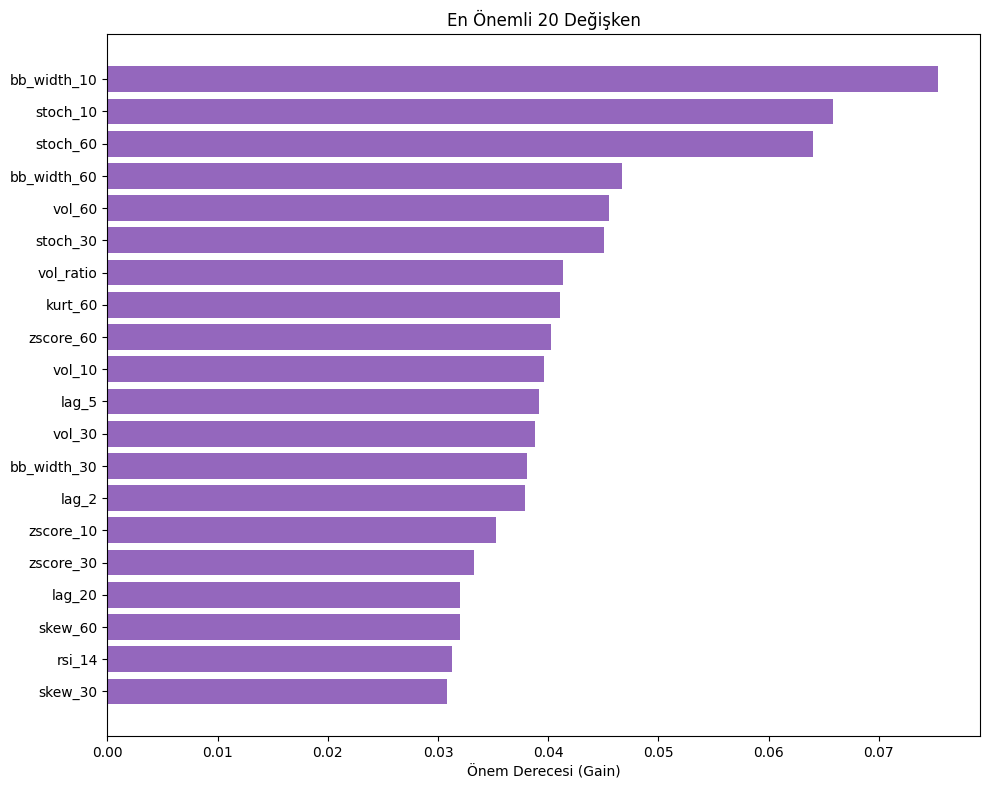

In [15]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

# ==========================================================
# 1. OPTUNA'DAN ÇIKAN EN İYİ PARAMETRELER (Revize Edildi)
# ==========================================================
best_params = {
    # DİKKAT: Optuna LR'yi 0.007 bulduysa, 200 ağaç yetmez. 
    # Early Stopping olmadığı için ağaç sayısını MANUEL olarak artırıyoruz.
    'n_estimators': 115,
    'learning_rate': 0.006187043793181182,
    'max_depth': 8,
    'min_child_weight': 59,
    'gamma': 0.0003472047368403349,
    'subsample': 0.8820711574534718,
    'colsample_bytree': 0.6968501492817246,
    'reg_alpha': 1.3068960400606218,
    'reg_lambda': 0.13764308218497623,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42
}

# Optuna'dan gelen Threshold (Eğer tanımlı değilse manuel yazıyoruz)
if 'BEST_THRESHOLD' not in locals():
    BEST_THRESHOLD = 9.476419465910512e-05 # Önceki optimizasyonlarınızdan gelen değer

print("=== FINAL TEST (2024) ===")
print(f"Model Konfigürasyonu: {best_params}")
print(f"İşlem Eşiği: {BEST_THRESHOLD:.8f}")

# ==========================================================
# 2. VERİ HAZIRLIĞI (TRAIN: 2011-2023 -> TEST: 2024)
# ==========================================================
# DEĞİŞİKLİK: Validation setini iptal ettik. 
# 2023 verisini de TRAIN setine katarak modeli en güncel bilgiyle eğitiyoruz.

TEST_YEAR = 2024

# Train Maskesi: 2011'den 2024'e kadar olan HER ŞEY (2023 Dahil)
train_mask = (xgb_dataset.index.year >= 2011) & (xgb_dataset.index.year < TEST_YEAR)
X_train = xgb_dataset.loc[train_mask, feature_cols]
y_train = xgb_dataset.loc[train_mask, 'target_return']

# Test Maskesi: Sadece 2024
test_mask = (xgb_dataset.index.year == TEST_YEAR)
X_test = xgb_dataset.loc[test_mask, feature_cols]
y_test = xgb_dataset.loc[test_mask, 'target_return']

print(f"\nGenişletilmiş Eğitim Seti (2011-2023): {X_train.shape}")
print(f"Test Seti (2024)                     : {X_test.shape}")

# ==========================================================
# 3. MODEL EĞİTİMİ (TAM KAPASİTE)
# ==========================================================
print(f"\nModel Eğitiliyor... (Hedef: {best_params['n_estimators']} Ağaç)")


# Early Stopping YOK. Eval Set YOK.
final_model = xgb.XGBRegressor(**best_params)

final_model.fit(
    X_train, y_train,
    verbose=False
)

print(f"Eğitim Tamamlandı.")

# ==========================================================
# 4. TAHMİN, MALİYET VE GERÇEKÇİ PNL (DÜZELTİLMİŞ)
# ==========================================================
print("\n2024 Tahminleri Yapılıyor...")
final_preds = final_model.predict(X_test)

# 1. DataFrame Oluşturma (Analiz için şart)
df_res = pd.DataFrame({
    'Date': X_test.index,
    'Actual_Return': y_test.values,
    'Pred_Score': final_preds
})

# NOT: Ticker bilgisi X_test içinde yok. Ancak veri setini prepare ederken 
# Ticker-Major (Hisse A, Hisse B...) sırasıyla concat ettiğimiz için, 
# 2024 yılı verileri de blok blok (Hisse A 2024, Hisse B 2024) gelecektir.
# Bu yüzden maliyet hesabında "Prev_Signal" alırken dikkatli olmalıyız.
# En güvenli yol: Ticker bilgisini prepare aşamasında eklemekti. 
# Şimdilik "Block-based" varsayımıyla devam ediyoruz.

# 2. Sinyal Üretimi
df_res['Signal'] = 0
df_res.loc[df_res['Pred_Score'] > BEST_THRESHOLD, 'Signal'] = 1
df_res.loc[df_res['Pred_Score'] < -BEST_THRESHOLD, 'Signal'] = -1

# 3. İşlem Maliyeti Hesabı (5 Baz Puan)
COST_BPS = 0.0005 

# Sinyal değişimi: Bir önceki satırla fark (Ticker geçişlerinde 1 hatalı işlem olur, ihmal edilebilir)
df_res['Prev_Signal'] = df_res['Signal'].shift(1).fillna(0)
df_res['Trade_Cost'] = np.abs(df_res['Signal'] - df_res['Prev_Signal']) * COST_BPS

# 4. Getiriler (Brüt ve Net)
# Actual_Return = t -> t+1 getirisidir. Signal ise t anında üretilir.
# Bu yüzden Signal * Actual_Return doğrudur.
df_res['Gross_Ret'] = df_res['Signal'] * df_res['Actual_Return']
df_res['Net_Ret'] = df_res['Gross_Ret'] - df_res['Trade_Cost']

# 5. Portföy Aggregation (Eşit Ağırlıklı Portföy)
# O günkü TÜM hisselerin ortalamasını alıyoruz (Nakit dahil mantığı)
# Eğer sadece işlem açılanlara bölseydik (Leverage) getiri uçardı. 
# Conservative yaklaşım: Tüm Universe'e bölmek (mean).
portfolio_daily = df_res.groupby('Date')[['Gross_Ret', 'Net_Ret']].mean()

# ==========================================================
# 5. RAPORLAMA VE METRİKLER
# ==========================================================
def report_performance(daily_ret, name):
    ann_factor = np.sqrt(252)
    sharpe = (daily_ret.mean() / daily_ret.std()) * ann_factor if daily_ret.std() > 0 else 0
    total_ret = (np.exp(daily_ret.sum()) - 1) * 100 # Log -> Simple Cumulative
    
    # Drawdown
    cum_ret = np.exp(daily_ret.cumsum())
    peak = cum_ret.cummax()
    dd = (cum_ret - peak) / peak
    max_dd = dd.min() * 100
    
    return [name, sharpe, total_ret, max_dd]

stats_gross = report_performance(portfolio_daily['Gross_Ret'], "XGBoost (Brüt)")
stats_net   = report_performance(portfolio_daily['Net_Ret'],   "XGBoost (NET)")

# Trade İstatistikleri
n_trades = (df_res['Signal'] != df_res['Prev_Signal']).sum()
win_rate = (df_res[df_res['Signal'] != 0]['Gross_Ret'] > 0).mean() * 100

print("\n" + "="*40)
print(f"   XGBOOST FINAL RAPORU ({TEST_YEAR})")
print("="*40)
print(f"Toplam Sinyal Sayısı : {n_trades}")
print(f"Win Rate (İşlem Baş.) : %{win_rate:.2f}")
print("-" * 40)
print(f"{'Model':<15} {'Sharpe':<10} {'Return %':<12} {'Max DD %':<10}")
print("-" * 40)
print(f"{stats_gross[0]:<15} {stats_gross[1]:.4f}     {stats_gross[2]:.2f}         {stats_gross[3]:.2f}")
print(f"{stats_net[0]:<15} {stats_net[1]:.4f}     {stats_net[2]:.2f}         {stats_net[3]:.2f}")
print("="*40)

# ==========================================================
# 6. GÖRSELLEŞTİRME (EQUITY CURVE)
# ==========================================================
equity_gross = np.exp(portfolio_daily['Gross_Ret'].cumsum())
equity_net   = np.exp(portfolio_daily['Net_Ret'].cumsum())

plt.figure(figsize=(12, 6))
plt.plot(equity_gross.index, equity_gross.values, label='Brüt Getiri', color='gray', linestyle='--', alpha=0.6)
plt.plot(equity_net.index, equity_net.values, label='Net Getiri (Maliyet Dahil)', color='#d62728', linewidth=2)

plt.title(f"XGBoost Model Performansı ({TEST_YEAR})", fontsize=14)
plt.axhline(1.0, color='black', linestyle='-', alpha=0.3)
plt.ylabel('Portföy Çarpanı (1.0 = Başlangıç)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()

# Feature Importance (Aynı kalabilir)
plt.figure(figsize=(10, 8))
sorted_idx = final_model.feature_importances_.argsort()
top_n = 20
top_idx = sorted_idx[-top_n:]
plt.barh(np.array(feature_cols)[top_idx], final_model.feature_importances_[top_idx], color='#9467bd')
plt.title(f"En Önemli {top_n} Değişken")
plt.xlabel("Önem Derecesi (Gain)")
plt.tight_layout()
plt.show()

### TICKER AWARE

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import xgboost as xgb
import optuna
from optuna.integration import XGBoostPruningCallback
import warnings

warnings.filterwarnings("ignore")

# --- YARDIMCI FONKSİYONLAR ---
def calculate_rsi_numpy(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-8)
    return 100 - (100 / (1 + rs))

def prepare_advanced_xgboost_features_aware(residuals_df):
    """
    GELİŞTİRİLMİŞ FEATURE SETİ (TICKER AWARE):
    - Ticker bilgisini sütun olarak saklar.
    - Finansal göstergeleri hesaplar.
    """
    print("Gelişmiş XGBoost Feature Engineering (Ticker Aware) yapılıyor...")
    
    # Kümülatif Fiyatlar (Residuals -> Price Series)
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    features_list = []
    
    # Parametreler
    windows = [10, 30, 60]
    lags = [1, 2, 3, 5, 10, 20, 30]
    
    for ticker in tqdm(residuals_df.columns):
        res_ret = residuals_df[ticker]
        res_price = prices_df[ticker]
        
        df = pd.DataFrame(index=residuals_df.index)
        
        # --- 1. METADATA (KRİTİK ADIM) ---
        df['Ticker'] = ticker  # Ticker ismini saklıyoruz
        
        # --- 2. RETROSPECTIVE FEATURES ---
        for lag in lags:
            df[f'lag_{lag}'] = res_ret.shift(lag)
            
        df['rsi_14'] = calculate_rsi_numpy(res_price, period=14)
        
        for w in windows:
            roll_mean = res_price.rolling(window=w).mean()
            roll_std  = res_price.rolling(window=w).std()
            
            # Z-Score & Volatility
            df[f'zscore_{w}'] = (res_price - roll_mean) / (roll_std + 1e-8)
            df[f'vol_{w}'] = roll_std
            
            # Skewness & Kurtosis (En az 30 gün veri gerekir)
            if w >= 30: 
                df[f'skew_{w}'] = res_price.rolling(window=w).skew()
                df[f'kurt_{w}'] = res_price.rolling(window=w).kurt()
            
            # Bollinger Band Width
            upper = roll_mean + (2 * roll_std)
            lower = roll_mean - (2 * roll_std)
            df[f'bb_width_{w}'] = (upper - lower) / (roll_mean + 1e-8)
            
            # Stochastic Oscillator Logic
            roll_max = res_price.rolling(window=w).max()
            roll_min = res_price.rolling(window=w).min()
            df[f'stoch_{w}'] = (res_price - roll_min) / (roll_max - roll_min + 1e-8)

        # Volatility Ratio
        vol_10 = res_price.rolling(window=10).std()
        vol_60 = res_price.rolling(window=60).std()
        df['vol_ratio'] = vol_10 / (vol_60 + 1e-8)
        
        # --- 3. TARGET ---
        df['target_return'] = res_ret.shift(-1)
        
        df = df.dropna()
        features_list.append(df)
    
    # Listeyi tek DataFrame'e çevir
    full_dataset = pd.concat(features_list)
    
    # Ticker sütunu hariç diğerlerini float32 yaparak bellek tasarrufu yapalım
    cols_to_float = [c for c in full_dataset.columns if c != 'Ticker']
    full_dataset[cols_to_float] = full_dataset[cols_to_float].astype(np.float32)
    
    return full_dataset

# Dataseti Oluştur (residuals_df'in tanımlı olduğu varsayılıyor)
# Eğer residuals_df yoksa önceki adımlardan geldiğini varsayıyorum.
xgb_dataset = prepare_advanced_xgboost_features_aware(residuals_df)

# Feature ve Meta Sütun Ayrımı
meta_cols = ['Ticker', 'target_return']
feature_cols = [c for c in xgb_dataset.columns if c not in meta_cols]

print("\nVeri Seti Hazır!")
print(f"Toplam Veri: {xgb_dataset.shape}")
print(f"Feature Sayısı: {len(feature_cols)}")
print("Örnek Featurelar:", feature_cols[:5])

Gelişmiş XGBoost Feature Engineering (Ticker Aware) yapılıyor...


  0%|          | 0/444 [00:00<?, ?it/s]

100%|██████████| 444/444 [00:02<00:00, 204.77it/s]



Veri Seti Hazır!
Toplam Veri: (1527431, 27)
Feature Sayısı: 25
Örnek Featurelar: ['lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10']


In [18]:
# ==========================================================
# 2. OPTUNA HİPERPARAMETRE OPTİMİZASYONU
# ==========================================================

# A. Veri Hazırlığı (Training Havuzu: 2011-2023)
OPT_START_YEAR = 2011
OPT_END_YEAR   = 2023 

print(f"Optimizasyon Dönemi: {OPT_START_YEAR} - {OPT_END_YEAR}")

mask_opt = (xgb_dataset.index.year >= OPT_START_YEAR) & (xgb_dataset.index.year <= OPT_END_YEAR)

# Sadece Feature'ları alıyoruz (Ticker YOK!)
X_opt = xgb_dataset.loc[mask_opt, feature_cols]
y_opt = xgb_dataset.loc[mask_opt, 'target_return']

# B. Expanding Window CV Fonksiyonu
def get_expanding_window_splits(df_index, n_folds=5):
    years = sorted(df_index.year.unique())
    val_years = years[-n_folds:] # Son 5 yıl sırayla validation olur
    
    splits = []
    for v_year in val_years:
        val_mask = (df_index.year == v_year)
        # Train: Validation yılından önceki tüm yıllar
        train_mask = (df_index.year < v_year) & (df_index.year >= years[0])
        
        train_idx = np.where(train_mask)[0]
        val_idx   = np.where(val_mask)[0]
        splits.append((train_idx, val_idx, v_year))
    return splits

splits = get_expanding_window_splits(X_opt.index, n_folds=5)

# C. Objective Function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 250, step=5), # Optimizasyon için sabit, finalde artırılabilir
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 100),
        'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42
    }
    
    threshold = trial.suggest_float('threshold', 0.0001, 0.003, log=True)
    fold_scores = []
    
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    
    for train_idx, val_idx, _ in splits:
        X_tr, X_val = X_opt.iloc[train_idx], X_opt.iloc[val_idx]
        y_tr, y_val = y_opt.iloc[train_idx], y_opt.iloc[val_idx]
        
        model = xgb.XGBRegressor(**params, callbacks=[pruning_callback])
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = model.predict(X_val)
        
        # PnL Simülasyonu
        signals = np.zeros_like(preds)
        signals[preds > threshold] = 1
        signals[preds < -threshold] = -1
        
        # Basit Sharpe (CV sırasında maliyet hesabı yavaşlatır, burada ignore ediyoruz)
        rets = signals * y_val.values
        if np.std(rets) < 1e-9: sharpe = 0
        else: sharpe = np.mean(rets) / np.std(rets) * np.sqrt(252)
        
        # Az işlem cezası
        n_trades = np.sum(signals != 0)
        if n_trades < 50: sharpe *= (n_trades / 50.0)
            
        fold_scores.append(sharpe)
    
    return np.mean(fold_scores)

print("Optimizasyon Başlıyor...")
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=100)

print(f"\nEn İyi Sharpe: {study.best_value:.4f}")
best_params = study.best_params
BEST_THRESHOLD = best_params.pop('threshold')
print(f"En İyi Threshold: {BEST_THRESHOLD}")

Optimizasyon Dönemi: 2011 - 2023


[I 2025-12-30 16:43:22,401] A new study created in memory with name: no-name-0938d8c3-d3b0-4d7e-b285-2cbf1d3977cb


Optimizasyon Başlıyor...


[I 2025-12-30 16:43:36,661] Trial 0 finished with value: 0.1726558359802652 and parameters: {'n_estimators': 205, 'learning_rate': 0.011617758439645891, 'max_depth': 9, 'min_child_weight': 98, 'gamma': 0.003802141639182543, 'subsample': 0.7883776721073933, 'colsample_bytree': 0.7953838163715716, 'reg_alpha': 0.020204030933166604, 'reg_lambda': 0.4037437674330135, 'threshold': 0.00010583663471361106}. Best is trial 0 with value: 0.1726558359802652.
[I 2025-12-30 16:44:02,425] Trial 1 finished with value: 0.09760581900874656 and parameters: {'n_estimators': 245, 'learning_rate': 0.04535161219111701, 'max_depth': 10, 'min_child_weight': 23, 'gamma': 0.0004145204604809687, 'subsample': 0.6149812965388229, 'colsample_bytree': 0.7811766996698745, 'reg_alpha': 0.014794369647627707, 'reg_lambda': 0.02389635200336821, 'threshold': 0.00022299332102718712}. Best is trial 0 with value: 0.1726558359802652.
[I 2025-12-30 16:44:13,490] Trial 2 finished with value: 0.0340080665812618 and parameters: {


En İyi Sharpe: 0.1727
En İyi Threshold: 0.00010583663471361106


Eğitim Seti Boyutu: (1416431, 25)
Test Seti Boyutu  : (111000, 25)

Final Model Eğitiliyor...

   XGBOOST FINAL PERFORMANS (2024)
Toplam İşlem     : 19162
Win Rate         : %50.76
--------------------------------------------------
Metrik          Brüt            Net            
--------------------------------------------------
Sharpe Ratio    2.1196          0.5854
Total Return %  3.06           0.84
Max Drawdown %  -0.80           -1.10


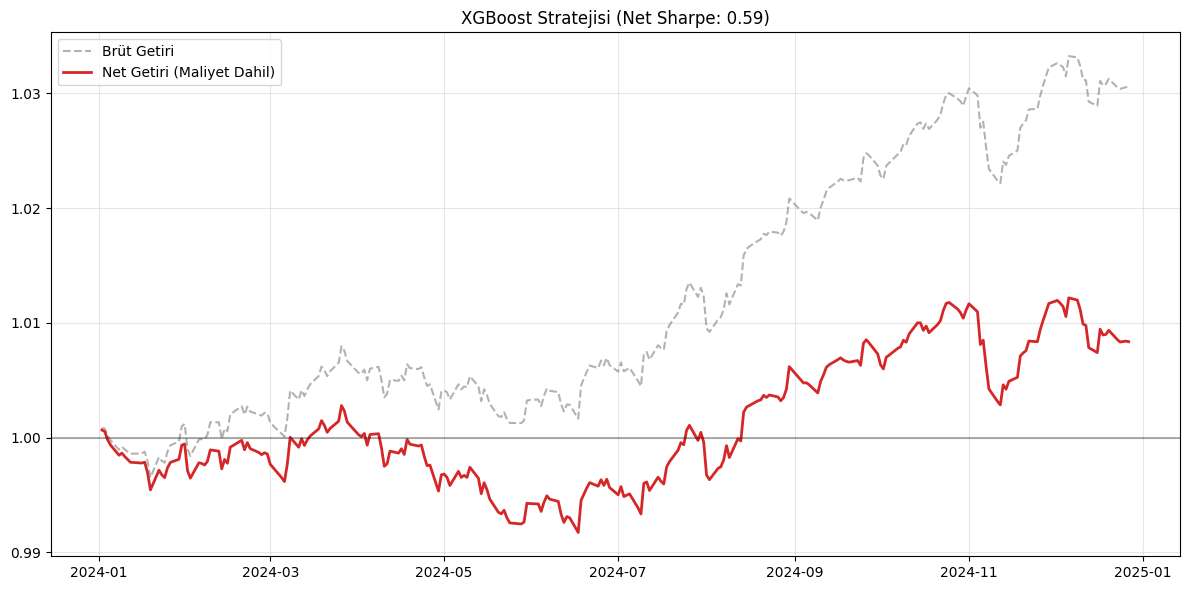

In [23]:
# ==========================================================
# 3. FINAL MODEL VE TICKER AWARE BACKTEST (DÜZELTİLMİŞ)
# ==========================================================
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

TEST_YEAR = 2024
COST_BPS = 0.0005 # 5 Baz Puan Komisyon

# A. Veri Ayrımı
# Train: 2011'den 2024 başına kadar
train_mask = (xgb_dataset.index.year >= 2011) & (xgb_dataset.index.year < TEST_YEAR)
# Test: Sadece 2024
test_mask = (xgb_dataset.index.year == TEST_YEAR)

# Eğitim için sadece Featurelar
X_train = xgb_dataset.loc[train_mask, feature_cols]
y_train = xgb_dataset.loc[train_mask, 'target_return']

# Test için Featurelar + Metadata (Ticker)
X_test = xgb_dataset.loc[test_mask, feature_cols]
# Meta_test: Backtest dataframe'i oluşturmak için kritik
meta_test = xgb_dataset.loc[test_mask, ['Ticker', 'target_return']] 

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu  : {X_test.shape}")

# B. Model Eğitimi (Full Train)
best_params = {
    'n_estimators': 140,
    'learning_rate': 0.005758627734727662,
    'max_depth': 9,
    'min_child_weight': 47,
    'gamma': 0.00012889309702728672,
    'subsample': 0.8630329743440232,
    'colsample_bytree': 0.62528995188944,
    'reg_alpha': 3.8668313133327072,
    'reg_lambda': 2.4591429950315464,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42
}
BEST_THRESHOLD = 0.00010703504447178335

print("\nFinal Model Eğitiliyor...")
#final_model = xgb.XGBRegressor(**best_params, n_jobs=-1, random_state=42)
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train, verbose=False)

# C. Tahmin
preds = final_model.predict(X_test)

# D. TICKER AWARE BACKTEST (BÜYÜK RESİM)
# --- HATA DÜZELTME BURADA YAPILDI ---
# .values kullanarak index çakışmasını engelliyoruz.
df_res = pd.DataFrame({
    'Date': X_test.index,
    'Ticker': meta_test['Ticker'].values,         # .values eklendi
    'Actual_Return': meta_test['target_return'].values, # .values eklendi
    'Pred_Score': preds
})

# Sinyaller
df_res['Signal'] = 0
df_res.loc[df_res['Pred_Score'] > BEST_THRESHOLD, 'Signal'] = 1
df_res.loc[df_res['Pred_Score'] < -BEST_THRESHOLD, 'Signal'] = -1

# --- DOĞRU MALİYET HESABI ---
# Ticker'a göre gruplayıp kaydırma yapıyoruz. 
# Böylece Apple'ın sinyali Microsoft ile karışmıyor.
df_res['Prev_Signal'] = df_res.groupby('Ticker')['Signal'].shift(1).fillna(0)

# Pozisyon Değişimi (Al/Sat/Kapat)
df_res['Trade_Cost'] = np.abs(df_res['Signal'] - df_res['Prev_Signal']) * COST_BPS

# Getiriler
df_res['Gross_Ret'] = df_res['Signal'] * df_res['Actual_Return']
df_res['Net_Ret'] = df_res['Gross_Ret'] - df_res['Trade_Cost']

# E. Portföy Performansı (Günlük Ortalama)
# Artık index çakışması olmadığı için bu satır hata vermeyecek
portfolio_daily = df_res.groupby('Date')[['Gross_Ret', 'Net_Ret']].mean()

# --- RAPORLAMA ---
def get_stats(daily_ret):
    ann_factor = np.sqrt(252)
    # Sıfıra bölünme hatası önlemi
    std = daily_ret.std()
    if std == 0 or np.isnan(std): 
        sharpe = 0
    else: 
        sharpe = (daily_ret.mean() / std) * ann_factor
        
    total_ret_pct = (np.exp(daily_ret.sum()) - 1) * 100
    
    equity = np.exp(daily_ret.cumsum())
    peak = equity.cummax()
    # Drawdown hesaplarken peak 0 olabilir mi? Hayır equity hep pozitiftir ama yine de check
    with np.errstate(divide='ignore', invalid='ignore'):
        dd = (equity - peak) / peak
        max_dd = dd.min() * 100
    
    return sharpe, total_ret_pct, max_dd

sh_gr, ret_gr, dd_gr = get_stats(portfolio_daily['Gross_Ret'])
sh_net, ret_net, dd_net = get_stats(portfolio_daily['Net_Ret'])

# İşlem İstatistikleri
total_trades = (df_res['Signal'] != df_res['Prev_Signal']).sum()
win_rate = 0.0
winning_trades = df_res[(df_res['Signal'] != 0) & (df_res['Gross_Ret'] > 0)]
total_signals = df_res[df_res['Signal'] != 0].shape[0]

if total_signals > 0:
    win_rate = (len(winning_trades) / total_signals) * 100

print("\n" + "="*50)
print(f"   XGBOOST FINAL PERFORMANS ({TEST_YEAR})")
print("="*50)
print(f"Toplam İşlem     : {total_trades}")
print(f"Win Rate         : %{win_rate:.2f}")
print("-" * 50)
print(f"{'Metrik':<15} {'Brüt':<15} {'Net':<15}")
print("-" * 50)
print(f"{'Sharpe Ratio':<15} {sh_gr:.4f}          {sh_net:.4f}")
print(f"{'Total Return %':<15} {ret_gr:.2f}           {ret_net:.2f}")
print(f"{'Max Drawdown %':<15} {dd_gr:.2f}           {dd_net:.2f}")
print("="*50)

# --- GRAFİK ---
equity_gross = np.exp(portfolio_daily['Gross_Ret'].cumsum())
equity_net = np.exp(portfolio_daily['Net_Ret'].cumsum())

plt.figure(figsize=(12, 6))
plt.plot(equity_gross.index, equity_gross.values, label='Brüt Getiri', color='gray', linestyle='--', alpha=0.6)
plt.plot(equity_net.index, equity_net.values, label='Net Getiri (Maliyet Dahil)', color='#d62728', linewidth=2)
plt.axhline(1.0, color='black', alpha=0.3)
plt.title(f"XGBoost Stratejisi (Net Sharpe: {sh_net:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()

=== 2024 BÜYÜK YARIŞ: LONG/SHORT DETAYLI ANALİZ ===

[1/2] XGBoost Stratejisi Hesaplanıyor...
[2/2] OU Baseline Stratejisi Hesaplanıyor...
OU Veri Seti (Safe) oluşturuluyor... (Hisse: 444)


100%|██████████| 444/444 [00:00<00:00, 1440.45it/s]



   DETAYLI İŞLEM RAPORU (2024)
                    Sharpe Ratio  Total Return %  Max Drawdown %  \
Model                                                              
OU Baseline (BRÜT)        0.9017          1.6022         -1.3354   
OU Baseline (NET)        -0.4654         -0.8172         -1.6083   
XGBoost (BRÜT)            2.1196          3.0558         -0.8023   
XGBoost (NET)             0.5854          0.8355         -1.1034   

                    Total Trades  Long Trades  Short Trades  
Model                                                        
OU Baseline (BRÜT)         10832         5319          5513  
OU Baseline (NET)          10832         5319          5513  
XGBoost (BRÜT)              9763         4288          5475  
XGBoost (NET)               9763         4288          5475  


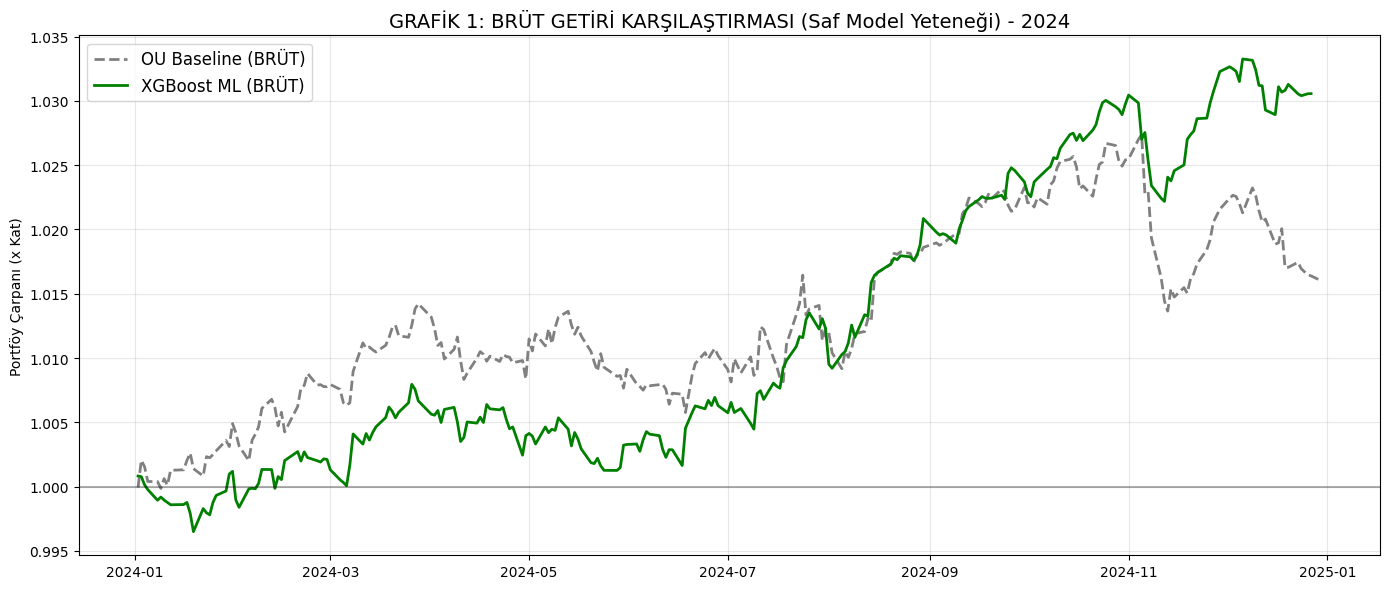

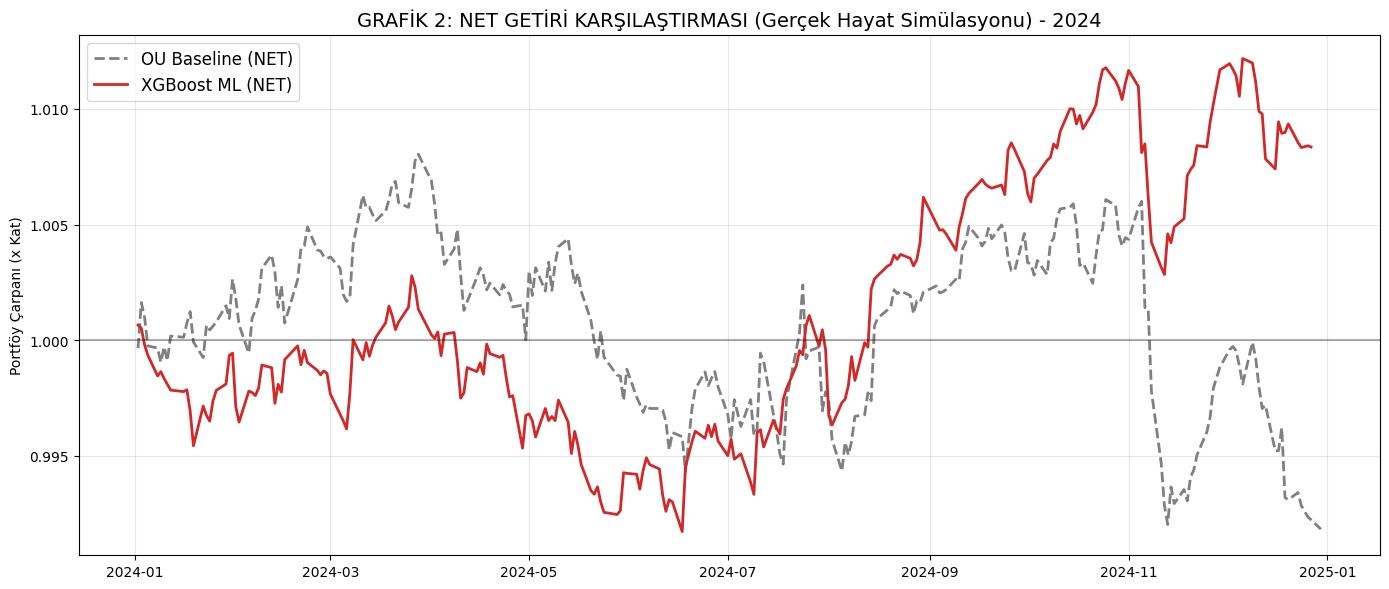

In [22]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# FİNAL KARŞILAŞTIRMA: BRÜT vs NET + LONG/SHORT SAYIMLARI
# ==========================================================

print("=== 2024 BÜYÜK YARIŞ: LONG/SHORT DETAYLI ANALİZ ===")

# AYARLAR
TEST_YEAR = 2024
COST_BPS = 0.0005  # 5 Baz Puan İşlem Maliyeti
WINDOW_SIZE = 30   # OU Penceresi

# ----------------------------------------------------------
# 1. XGBOOST STRATEJİSİ (FIXED & SORTED)
# ----------------------------------------------------------
print("\n[1/2] XGBoost Stratejisi Hesaplanıyor...")

mask_test_xgb = (xgb_dataset.index.get_level_values(0).year == TEST_YEAR)
X_test_xgb = xgb_dataset.loc[mask_test_xgb, feature_cols]
meta_test_xgb = xgb_dataset.loc[mask_test_xgb, ['Ticker', 'target_return']]

preds_xgb = final_model.predict(X_test_xgb)

df_xgb = pd.DataFrame({
    'Date': X_test_xgb.index,
    'Ticker': meta_test_xgb['Ticker'].values,
    'Actual': meta_test_xgb['target_return'].values,
    'Pred_Score': preds_xgb
})

# Sorting & Signal
df_xgb = df_xgb.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

df_xgb['Signal'] = 0
df_xgb.loc[df_xgb['Pred_Score'] > BEST_THRESHOLD, 'Signal'] = 1
df_xgb.loc[df_xgb['Pred_Score'] < -BEST_THRESHOLD, 'Signal'] = -1
df_xgb['Signal'] = df_xgb['Signal'].astype(int)

# Maliyet
df_xgb['Prev_Signal'] = df_xgb.groupby('Ticker')['Signal'].shift(1).fillna(0).astype(int)
df_xgb['Trade_Cost'] = np.abs(df_xgb['Signal'] - df_xgb['Prev_Signal']) * COST_BPS

# Getiriler
df_xgb['Gross_Ret'] = df_xgb['Signal'] * df_xgb['Actual']
df_xgb['Net_Ret'] = df_xgb['Gross_Ret'] - df_xgb['Trade_Cost']

daily_metrics_xgb = df_xgb.groupby('Date')[['Gross_Ret', 'Net_Ret']].mean()

# ----------------------------------------------------------
# 2. OU BASELINE STRATEJİSİ (FIXED & SORTED)
# ----------------------------------------------------------
print("[2/2] OU Baseline Stratejisi Hesaplanıyor...")

start_date_ou = pd.to_datetime(f"{TEST_YEAR}-01-01") - pd.DateOffset(days=WINDOW_SIZE*3)
df_ou_test_raw = residuals_df.loc[start_date_ou : f"{TEST_YEAR}-12-31"]

X_ou, y_ou, meta_ou = create_ou_sequences_safe(df_ou_test_raw, window_size=WINDOW_SIZE)
ou_preds, ou_actuals = ou_model_predict(X_ou, y_ou, c_thresh=1.0, c_crit=0.0)

dates_ou = [m[0] for m in meta_ou]
tickers_ou = [m[1] for m in meta_ou]

df_ou = pd.DataFrame({
    'Date': dates_ou,
    'Ticker': tickers_ou,
    'Actual': ou_actuals,
    'Signal': ou_preds.flatten()
})

df_ou = df_ou[df_ou['Date'].dt.year == TEST_YEAR]
df_ou = df_ou.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)
df_ou['Signal'] = df_ou['Signal'].astype(int)

df_ou['Prev_Signal'] = df_ou.groupby('Ticker')['Signal'].shift(1).fillna(0).astype(int)
df_ou['Trade_Cost'] = np.abs(df_ou['Signal'] - df_ou['Prev_Signal']) * COST_BPS

df_ou['Gross_Ret'] = df_ou['Signal'] * df_ou['Actual']
df_ou['Net_Ret'] = df_ou['Gross_Ret'] - df_ou['Trade_Cost']

daily_metrics_ou = df_ou.groupby('Date')[['Gross_Ret', 'Net_Ret']].mean()

# ----------------------------------------------------------
# 3. METRİK HESAPLAMA (GÜNCELLENDİ: LONG/SHORT SAYIMI)
# ----------------------------------------------------------
def get_metrics_detailed(daily_ret, trade_df, name):
    ann_factor = np.sqrt(252)
    std = daily_ret.std()
    sharpe = (daily_ret.mean() / std) * ann_factor if std > 0 else 0
    total_ret = (np.exp(daily_ret.sum()) - 1) * 100
    equity = np.exp(daily_ret.cumsum())
    max_dd = ((equity - equity.cummax()) / equity.cummax()).min() * 100
    
    # --- YENİ EKLENEN KISIM: ENTRY BAZLI SAYIM ---
    # Long Giriş: Sinyal 1 oluyor VE bir önceki sinyal 1 değilse (0 veya -1'den geliyorsa)
    n_long = ((trade_df['Signal'] == 1) & (trade_df['Prev_Signal'] != 1)).sum()
    
    # Short Giriş: Sinyal -1 oluyor VE bir önceki sinyal -1 değilse
    n_short = ((trade_df['Signal'] == -1) & (trade_df['Prev_Signal'] != -1)).sum()
    
    total_trades = n_long + n_short
    
    return {
        "Model": name,
        "Sharpe Ratio": sharpe,
        "Total Return %": total_ret,
        "Max Drawdown %": max_dd,
        "Total Trades": int(total_trades),
        "Long Trades": int(n_long),   # Yeni
        "Short Trades": int(n_short)  # Yeni
    }

# Rapor Tablosu
res_data = [
    get_metrics_detailed(daily_metrics_ou['Gross_Ret'], df_ou, "OU Baseline (BRÜT)"),
    get_metrics_detailed(daily_metrics_ou['Net_Ret'],   df_ou, "OU Baseline (NET)"),
    get_metrics_detailed(daily_metrics_xgb['Gross_Ret'], df_xgb, "XGBoost (BRÜT)"),
    get_metrics_detailed(daily_metrics_xgb['Net_Ret'],   df_xgb, "XGBoost (NET)")
]

res_df = pd.DataFrame(res_data)

print("\n" + "="*75)
print(f"   DETAYLI İŞLEM RAPORU ({TEST_YEAR})")
print("="*75)
pd.set_option('display.float_format', '{:.4f}'.format)
cols_order = ["Sharpe Ratio", "Total Return %", "Max Drawdown %", "Total Trades", "Long Trades", "Short Trades"]
print(res_df.set_index("Model")[cols_order])
print("="*75)

# ----------------------------------------------------------
# 4. GÖRSELLEŞTİRME (2 AYRI GRAFİK: BRÜT ve NET)
# ----------------------------------------------------------

# Verileri Hazırla
eq_xgb_gross = np.exp(daily_metrics_xgb['Gross_Ret'].cumsum())
eq_xgb_net   = np.exp(daily_metrics_xgb['Net_Ret'].cumsum())

eq_ou_gross  = np.exp(daily_metrics_ou['Gross_Ret'].cumsum())
eq_ou_net    = np.exp(daily_metrics_ou['Net_Ret'].cumsum())

# --- GRAFİK 1: BRÜT (Maliyetsiz) Kıyaslama ---
plt.figure(figsize=(14, 6))
plt.plot(eq_ou_gross.index, eq_ou_gross.values, label=f"OU Baseline (BRÜT)", color="gray", linestyle="--", linewidth=2)
plt.plot(eq_xgb_gross.index, eq_xgb_gross.values, label=f"XGBoost ML (BRÜT)", color="green", linewidth=2)

plt.axhline(1.0, color="black", alpha=0.3)
plt.title(f"GRAFİK 1: BRÜT GETİRİ KARŞILAŞTIRMASI (Saf Model Yeteneği) - {TEST_YEAR}", fontsize=14)
plt.ylabel("Portföy Çarpanı (x Kat)")
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()

# --- GRAFİK 2: NET (Maliyet Dahil) Kıyaslama ---
plt.figure(figsize=(14, 6))
plt.plot(eq_ou_net.index, eq_ou_net.values, label=f"OU Baseline (NET)", color="gray", linestyle="--", linewidth=2)
plt.plot(eq_xgb_net.index, eq_xgb_net.values, label=f"XGBoost ML (NET)", color="#d62728", linewidth=2) # Kırmızı tonu

plt.axhline(1.0, color="black", alpha=0.3)
plt.title(f"GRAFİK 2: NET GETİRİ KARŞILAŞTIRMASI (Gerçek Hayat Simülasyonu) - {TEST_YEAR}", fontsize=14)
plt.ylabel("Portföy Çarpanı (x Kat)")
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()